
## Гибридные рекомендательные системы с Surprise: взвешенный подход

Дедлайн 1: 18 октября. Дедлайн 2 (максимальная оценка - 1 балл) 25 октября

### Мы используем Suprise (пакет sci-kit для рекомендательных систем), чтобы гарантировать, что рекомендательные системы, которые мы используем, оптимизированы, чтобы когда мы объединили их - не беспокоились о недостатках, возникающих в отдельной реализации. 

In [1]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 6.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633975 sha256=1b013c392665570c359747b530540c72c160eade4fd9addc2d45659a16f2e5f1
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import surprise
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os

Во-первых, давайте прочитаем и очистим набор данных, чтобы мы знали, с чем работаем.
1. Считайте pandas датафрейм ratings.csv
2. Удалите дублированные строки
3. Сколько уникальных книг и пользователей в датасете?
4. В каком интервале рейтинг?

In [3]:
raw = pd.read_csv('input_goodreads/ratings.csv')
raw.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
print("Rows with duplicates:", raw.shape[0])
raw = raw.drop_duplicates()
print("Rows without duplicates:", raw.shape[0])
print("Rating interval: [", raw['rating'].min(), ",", raw['rating'].max(), "]")
raw.nunique()

Rows with duplicates: 981756
Rows without duplicates: 980112
Rating interval: [ 1 , 5 ]


book_id    10000
user_id    53424
rating         5
dtype: int64

Всякий раз, когда вы загружаете набор данных в Surprise, вы можете использовать их класс Reader набора данных, который облегчает большую часть проблем. Вы можете указать множество форматов файлов, но для фреймов данных pandas, которые мы используем, вы можете указать некоторые параметры для рейтинга (rating_scale) и датафрейма.

In [5]:
from surprise.dataset import DatasetAutoFolds 

In [6]:
#порядок колонок должен быть таким
raw = raw[['user_id','book_id','rating']] 
raw.columns = ['n_users','n_items','rating']

# укажем scale для рейтинга
reader = surprise.Reader(rating_scale=(1,5)) 

# разделите на основную и отложенную выборки в соотножении 3:1
# и загрузите в surprise dataset:
#  -- TODO -- 
rawTrain,rawholdout = train_test_split(raw, test_size = 0.25) #None, None
data = surprise.Dataset.load_from_df(rawTrain, reader)
holdout = surprise.Dataset.load_from_df(rawholdout, reader)


### Во-первых, выберем несколько алгоритмов для включения в наш ансамбль. Это будут
1. KNN совместная фильтрация 
2. Матричная факторизация
3. Совместная фильтрация с кластеризацией
4. Совместная фильтрация на основе алгоритма Slope One. (http://wiki-org.ru/wiki/Slope_One)

## KNN колаборативная фильтрация:

In [7]:
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True) # разбиваем данные на фолды

Задайте параметр sim_options на основании косинусной меры, и с подходом user-based ('user_based': False)

In [8]:
sim_options = {
    "name": "cosine",
    "user_based": False,
}
collabKNN = surprise.KNNBasic(k=40,sim_options=sim_options)

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [9]:
rmseKNN = []
# -- TODO --
for trainset, testset in kSplit.split(data): #проходимся по фолдам
    collabKNN.fit(trainset)
    rmseKNN.append(surprise.accuracy.rmse(collabKNN.test(testset)))
    
print(rmseKNN)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8981
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8966
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9008
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8949
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8915
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8987
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8991
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9038
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8981
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8953
[0.8980699624009123, 0.896604192965681, 0.9007809849644528, 0.8948636423732385, 0.8915239446115325, 0.89865344

### Вы можете пробовать разные гиперпараметры, используя Suprise Grid Search CV, чтобы найти наилучшие возможные гиперпараметры.


### Обучим наш алгоритм матричной факторизации с 30 скрытыми факторами (n_factors=30)


In [10]:
funkSVD = surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=30,n_epochs=10,biased=True)

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [11]:
rmseSVD = []
for trainset, testset in kSplit.split(data): #проходимся по фолдам
    funkSVD.fit(trainset)
    rmseSVD.append(surprise.accuracy.rmse(funkSVD.test(testset)))
print(rmseSVD)

RMSE: 0.8506
RMSE: 0.8532
RMSE: 0.8498
RMSE: 0.8531
RMSE: 0.8507
RMSE: 0.8504
RMSE: 0.8537
RMSE: 0.8488
RMSE: 0.8517
RMSE: 0.8518
[0.8505917184080828, 0.8531885935761233, 0.849792030120394, 0.8531264896715884, 0.8507239138165199, 0.8504490179679823, 0.8536720665743651, 0.8487995724560458, 0.8516833148259162, 0.8517563367396468]


## Колаборативная фильтрация с кластеризацией


Теперь используем совместную фильтрацию с кластеризацией.
Совместная кластеризация - это объединение пользователей и элементов в кластеры с использованием методов кластеризации. Выделите три кластера. Чтобы получить прогнозируемый рейтинг, вам нужно будет суммировать три вещи:
     1. Вы находите кластер для указанного рейтинга пользователя u и элемента i и определяете среднее значение этого кластера. Итак, вы найдете среднее значение кластера u_i.
     2. Найдите среднее значение кластера элемента i и вычтите его из среднего рейтинга этого элемента.
     3. Найдите среднее значение кластера пользователя u и вычтите его из среднего рейтинга этого пользователя.
    
Вы обнаружите, что для большинства из них RSME остается неизменным для всех K-фолдов.

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [12]:
coClus = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25) 
rmseCo = []
for trainset, testset in kSplit.split(data): #проходимся по фолдам
    coClus.fit(trainset)
    rmseCo.append(surprise.accuracy.rmse(coClus.test(testset)))
print(rmseCo)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


RMSE: 0.8863
RMSE: 0.8872
RMSE: 0.8849
RMSE: 0.8855
RMSE: 0.8857
RMSE: 0.8914
RMSE: 0.8860
RMSE: 0.8884
RMSE: 0.8905
RMSE: 0.8849
[0.8863251473577477, 0.8871693224713068, 0.8848800710661723, 0.8855178879859296, 0.8856882076469745, 0.8914262725446368, 0.8859955373745169, 0.8883717247846221, 0.8905489913800987, 0.8849471309899728]


## Slope One

Обучая нашу последнюю модель, мы будем использовать алгоритм совместной фильтрации Slope One. Этот алгоритм вычисляет наклон (slope) каждого из релевантных элементов, оцененных пользователем, находит разницу, а затем вычисляет прогноз. Это грубый инструмент, но это хорошая эвристика, которая может улучшить наш метод ансамбля. Подробнее читайте здесь: https://arxiv.org/abs/cs/0702144.

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [13]:
slopeOne = surprise.prediction_algorithms.slope_one.SlopeOne()

In [14]:
rmseSlope = []
for trainset, testset in kSplit.split(data): 
    slopeOne.fit(trainset)
    rmseSlope.append(surprise.accuracy.rmse(slopeOne.test(testset)))
print(rmseSlope)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE: 0.9271
RMSE: 0.9272
RMSE: 0.9255
RMSE: 0.9205
RMSE: 0.9260
RMSE: 0.9213
RMSE: 0.9316
RMSE: 0.9252
RMSE: 0.9249
RMSE: 0.9252
[0.9270557976045772, 0.9272301498477534, 0.9254557097896967, 0.9205096817452388, 0.9260060992663632, 0.921340802519832, 0.931554964192207, 0.9252337363039143, 0.9249368868906479, 0.9251574237766738]


Теперь у нас есть четыре рекомендательные системы, из которых мы хотим сделать ансамбль. Сначала давайте построим график каждого из них, чтобы увидеть, как они работают.

Затем реализуем описанный алгоритм Ensemble для гибридного подхода.

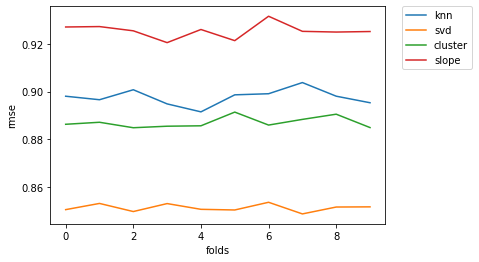

In [15]:
#Отобразим предсказания:
import matplotlib.pyplot as plt
modelPrediction = plt.plot(rmseKNN,label='knn')
modelPrediction = plt.plot(rmseSVD,label='svd')
modelPrediction = plt.plot(rmseCo,label='cluster')
modelPrediction = plt.plot(rmseSlope,label='slope')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Похоже, что svd превосходит остальные. Попробуем гибридизировать модели, чтобы получить лучшие части каждой модели. Для этого мы собираемся использовать Suprise, чтобы создать новый алгоритм, и сделать так, чтобы он превосходил остальные.


# На псевдокоде наш алгоритм выглядит следующим образом:
1. Мы запускаем несколько рекомендательных систем для набора данных.
2. Инициализируем взвешенную переменную alpha равную 1 / q, где q - количество используемых нами рекомендательных систем.
3. Итоговый рейтинг будем считать как сумму взвещаных прогнозируемых рейтингов.
4. Используя градиентный спуск, оптимизируем альфа-член по пространству параметров, чтобы иметь возможность придать наибольший вес модели, которая может представлять лучший прогноз.

Теперь создадим класс в Surprise и унаследуем его от Algobase.

In [16]:
class HybridFacto(surprise.AlgoBase):
    def __init__(self,epochs, learning_rate,q,estimators):
        self.alpha = np.array([1/q]*q)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.collabKNN = estimators[0]
        self.funkSVD = estimators[1]
        self.coClus = estimators[2]
        self.slopeOne = estimators[3]
    
    def fit(self, train_set):
        holdout=train_set.build_full_trainset().build_testset()
        predictions = []
        predictions.append(self.collabKNN.test(holdout))
        predictions.append(self.funkSVD.test(holdout))
        predictions.append(self.coClus.test(holdout))
        predictions.append(self.slopeOne.test(holdout))
        for epoch in range(self.epochs):
            maeGradient = np.array([surprise.accuracy.mae(prediction) for prediction in predictions])
            newalpha =  self.alpha - maeGradient * self.learning_rate
            #проверка сходимости:
            if (newalpha - self.alpha).max() < 0.001:
                break
            self.alpha = newalpha
            
    def estimate(self,testset):
        algoResults=[np.array([i.est for i in collabKNN.test(testset)]),
                     np.array([i.est for i in funkSVD.test(testset)]),
                     np.array([i.est for i in coClus.test(testset)]),
                     np.array([i.est for i in slopeOne.test(testset)])]
        return self.alpha @ algoResults
        

давайте проверим его:
1. Инициализруйте Гибридную модель с 10 эпохами, learning_rate = 0.05, по 4 имеющимся моделям и обучите на holdout выборке
2. Посчитайте root mean squared error с использованием метрики из sklearn для получившегося результата
3. Отобразите на графике результаты метрики, полученые от одиночных моделей на предыдущих шагах вместе с результатом гибридной модели. Оцените результат

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# -- TODO --
estimators = [collabKNN, funkSVD, coClus, slopeOne]
hybrid = HybridFacto(10, 0.05, 4, estimators)
hybrid.fit(holdout)

rmseHyb = []
for trainset, testset in kSplit.split(data):
    predhybrid = hybrid.estimate(testset)
    test_r = [i[2] for i in testset]
    rmseHyb.append(mean_squared_error(test_r, predhybrid, squared=False))
print(rmseHyb)

MAE:  0.6784
MAE:  0.6719
MAE:  0.6793
MAE:  0.7081
[0.6448262201816171, 0.6486284106369702, 0.6520007801127575, 0.6473844665963374, 0.6485399426494849, 0.6459889624374404, 0.6475745230578878, 0.6449948890353717, 0.6467905636211085, 0.6460380358694991]


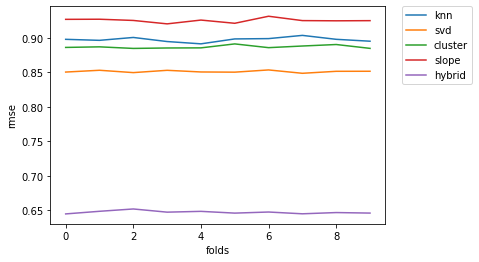

In [18]:
#plotting the prediction data:
modelPrediction = plt.plot(rmseKNN,label='knn')
modelPrediction = plt.plot(rmseSVD,label='svd')
modelPrediction = plt.plot(rmseCo,label='cluster')
modelPrediction = plt.plot(rmseSlope,label='slope')
modelPrediction = plt.plot(rmseHyb,label='hybrid')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Из полученных результатов видно, что гибридная модель дает значительно лучший результат в сравнении с одиночными